# Numerical Exercises 12



## Exercise 12.1

<span style="color:red">Change at will and train your DNN by increasing the number of epochs to an adequate value</span>. Try to use at least two other optimizers, different from SGD: <span style="color:red">watch to accuracy and loss for training and validation data and comment on the performances</span>.

## Solution

For this exercise i will use the same model used before but with different optimizers, i will set the number of epochs to a reasonable value until the accuracy will reach a plateau.


### Load data

In [1]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
from tensorflow import keras
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
import warnings
warnings.filterwarnings("ignore")
plt.rcParams.update({'font.size': 12})
plt.rcParams['font.family'] = 'serif'

an example of a data point with label 4


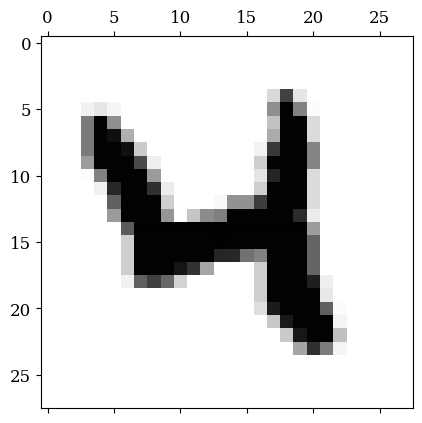

In [2]:
seed=0
# fix random seed
np.random.seed(seed) 
tf.random.set_seed(seed)

# load MNIST dataset
img_rows, img_cols = 28, 28 
num_classes = 10 
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

#print('X_train shape:', X_train.shape)
#print('Y_train shape:', Y_train.shape)

#reshape data
X_train = X_train.reshape(X_train.shape[0], img_rows*img_cols)
X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
#print('X_train shape:', X_train.shape)
#print('X_test shape:', X_test.shape)
#print()

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
# normalize data to [0,1] range
X_train /= 255
X_test /= 255

# look at an example of data point
print('an example of a data point with label', Y_train[20])
# matshow: display a matrix in a new figure window
plt.matshow(X_train[20,:].reshape(28,28),cmap='binary')
plt.show()

# convert class vectors to binary class matrices, e.g. for use with categorical_crossentropy
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)
#print('... and with label', Y_train[20], 'after to_categorical')
#print()
#print('X_train shape:', X_train.shape)
#print('Y_train shape:', Y_train.shape)

### Create model

In [3]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam

def create_DNN():
    # instantiate model
    model = Sequential()
    # add a dense all-to-all relu layer
    model.add(Dense(400,input_shape=(img_rows*img_cols,), activation='relu'))
    # add a dense all-to-all relu layer
    model.add(Dense(100, activation='relu'))
    # apply dropout with rate 0.5
    model.add(Dropout(0.5))
    # soft-max layer
    model.add(Dense(num_classes, activation='softmax'))
    #model.summary()
    
    return model

def compile_model(optimizer):
    # create the model
    model=create_DNN()
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=optimizer,
                  metrics=['acc'])
    return model

### Train and evaluate model

To train the model with different optimizers, i created a python script `training.py` that contains the code to train the model with different optimizers and save the results. 
i've implemented the same function above for the creation of the DNN model, but with the addition of a loop that iterates over the different optimizers. The results are saved in a folder called `data` in the current directory.

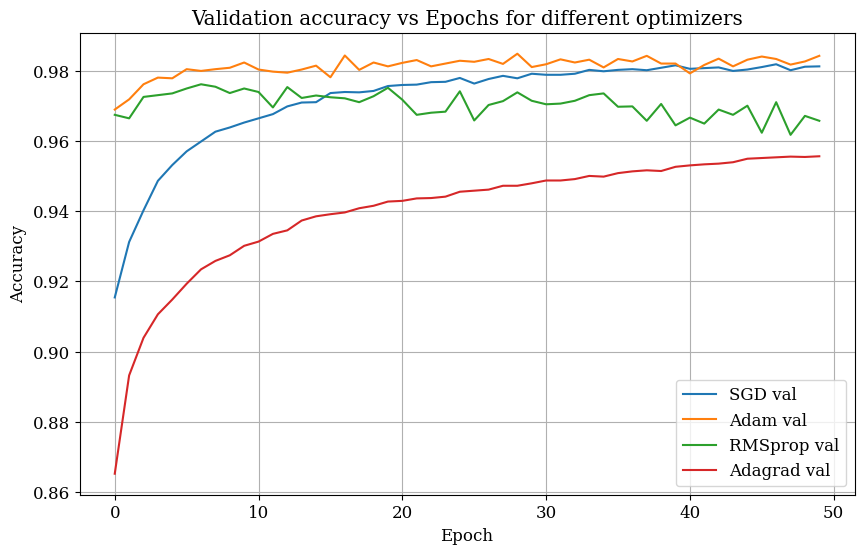

In [4]:
import pickle
import numpy as np

with open("data/dnn_histories.pkl", "rb") as f:
    histories = pickle.load(f)
scores = np.load("data/dnn_scores.npy", allow_pickle=True).item()

# Ora puoi plottare come prima:
plt.figure(figsize=(10, 6))
for opt in histories:
    plt.plot(histories[opt]['val_acc'], label=f'{opt} val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation accuracy vs Epochs for different optimizers')
plt.grid()
plt.legend()
plt.show()

The plot demonstrates the model's strong performance, achieving over 98% accuracy on the test set with SGD and Adam optimizers. This translates to more than 9,800 out of 10,000 images being correctly classified. As observed, SGD proves to be notably slower than the other optimizer. Adagrad seems to be the worst optimizer, with an accuracy of around 96% on the test set. Maybe this is due to a fast update of the learning rate, which makes the model converge too fast to a suboptimal solution and maybe has not already reached the plateau. 

RMSprop tends to overfit a little bit, but it still achieves a good accuracy on the test set. From now on i will use the model trained with Adam optimizer, as it is the best one in terms of accuracy and loss on the validation set.

To have a better understanding of the model performance, i will plot some examples of the predictions made by the model on the test set.

In [5]:
# Crea e allena un modello DNN con Adam come ottimizzatore
best_model_DNN = compile_model(optimizer=Adam())
batch_size = 32
epochs = 50

history = best_model_DNN.fit(
    X_train, Y_train,
    batch_size=batch_size,
    epochs=epochs,
    shuffle=True,
    verbose=0,
    validation_data=(X_test, Y_test)
)

In [6]:
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

def plot_predictions(predictions, images, labels, class_names=class_names, rows=4, cols=3, randomize=False):
    n_samples = rows * cols
    total = len(images)
    if randomize:
        idx = np.random.choice(total, n_samples, replace=False)
    else:
        idx = np.arange(n_samples)
    plt.figure(figsize=(4*cols, 2*rows))
    for i, img_idx in enumerate(idx):
        plt.subplot(rows, 2*cols, 2 * i + 1)
        plt.imshow(images[img_idx].reshape(28, 28), cmap="Greys")
        plt.yticks([])
        plt.xticks([])
        predicted_label = np.argmax(predictions[img_idx])
        true_label = labels[img_idx]
        color = 'green' if predicted_label == true_label else 'red'
        plt.xlabel(f"pred: {class_names[predicted_label]} actual: {class_names[true_label]}", color=color)

        plt.subplot(rows, 2*cols, 2 * i + 2)
        tp = plt.bar(range(10), predictions[img_idx], color='grey')
        tp[predicted_label].set_color('red')
        tp[true_label].set_color('blue')
        plt.yticks([])
        plt.xticks(range(10), class_names)
        plt.ylim([0,1])
        plt.text(0.5, 1.05, f"probability: {100*np.max(predictions[img_idx]):.0f}%",)
    plt.suptitle('Predictions vs True Labels', fontsize=16)
    plt.tight_layout()
    plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 545us/step


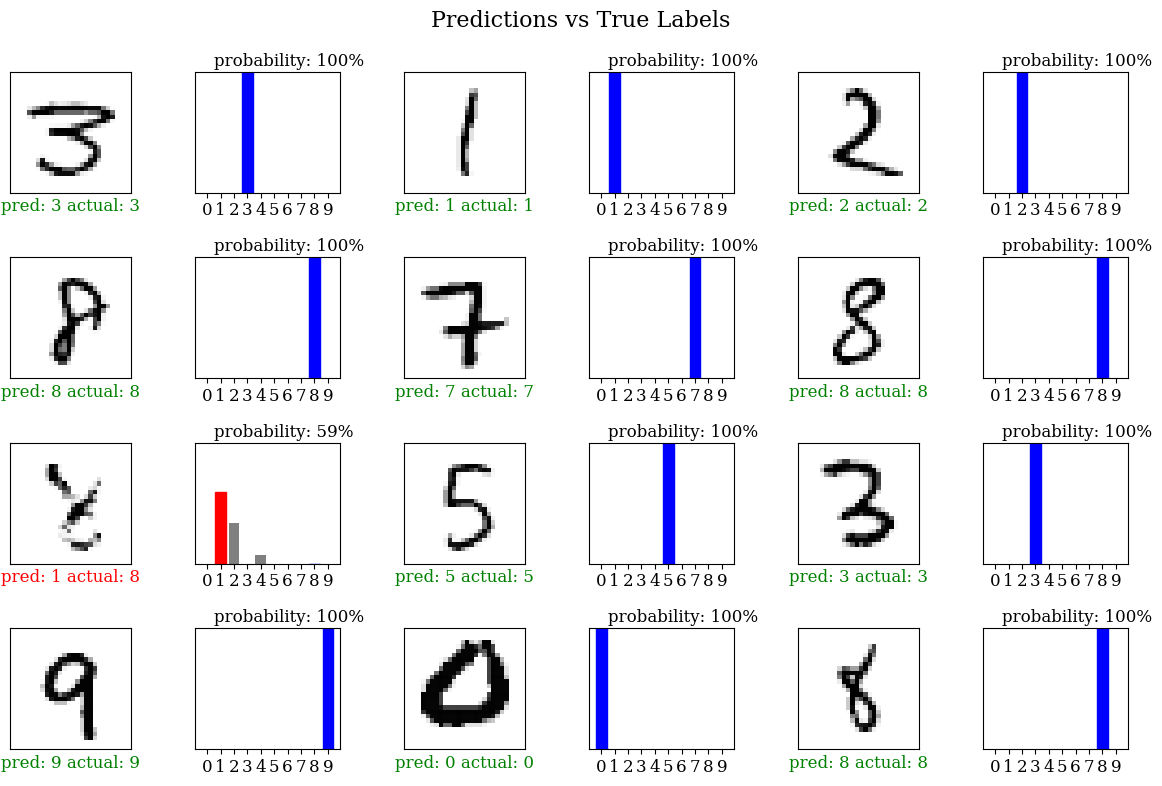

In [23]:
if X_test.ndim == 4 and X_test.shape[-1] == 1:
    images = X_test.squeeze(-1)
else:
    images = X_test

if Y_test.ndim > 1:
    labels = np.argmax(Y_test, axis=1)
else:
    labels = Y_test

X_test_flat = X_test.reshape(X_test.shape[0], -1)
predictions = best_model_DNN.predict(X_test_flat)
plot_predictions(predictions, images, labels, randomize=True)

Observing this plot and noting the misclassified digits (which sometimes even a human might struggle to identify correctly), it's evident that a 98% accuracy is an exceptional performance for the network, remember that the model flatten the image and then classify it, so it is not able to completely use the spatial information of the image.

## Exercise 12.2

Change the architecture of your DNN using convolutional layers. Use `Conv2D`, `MaxPooling2D`, `Dropout`, but also do not forget `Flatten`, a standard `Dense` layer and `soft-max` in the end. I have merged step 2 and 3 in the following definition of `create_CNN()` that **<span style="color:red">you should complete</span>**.

Train your DCNN and evaluate its performance proceeding exactly as before:

## Solution

For this exercise i will implement a CNN with 2 convolutional layers, 1 max pooling layer, 1 average pooling layer for the feature extraction. for the classification i will use a flatten layer, a dense layer with 128 neurons and a dropout layer to prevent overfitting. 

In [8]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, AveragePooling2D

def create_CNN():
    # instantiate model
    model = Sequential()
    # add first convolutional layer with 10 filters (dimensionality of output space)
    model.add(Conv2D(10, kernel_size=(5, 5),
                     activation='relu',
                     input_shape=(img_rows, img_cols, 1)))  # input shape for grayscale images
    model.add(MaxPooling2D(pool_size=(2, 2)))  # add max pooling layer
    model.add(Conv2D(20, kernel_size=(5, 5), activation='relu'))  # add another convolutional layer
    model.add(AveragePooling2D(pool_size=(2, 2)))  # add another max pooling layer

    model.add(Flatten())  # flatten the output to feed it to a dense layer
    model.add(Dense(100, activation='relu'))  # add a dense all-to-all relu layer
    model.add(Dense(60, activation='relu'))  # add another dense all-to-all relu layer
    model.add(Dropout(0.5))  # apply dropout with rate 0.5
    model.add(Dense(num_classes, activation='softmax'))  # soft-max layer
    
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer='SGD',
                  metrics=['acc'])
    return model

In [9]:
from tqdm.keras import TqdmCallback
# training parameters
batch_size = 32
epochs = 10

model_CNN=create_CNN()

# reshape data for CNN: (num_samples, 28, 28, 1)
X_train_cnn = X_train.reshape(-1, img_rows, img_cols, 1)
X_test_cnn = X_test.reshape(-1, img_rows, img_cols, 1)

# train CNN
model_CNN.fit(X_train_cnn, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          shuffle=True,
          verbose=0,
          validation_data=(X_test_cnn, Y_test),
          callbacks=[TqdmCallback(verbose=1, leave=True, desc="Training CNN")],
          )



Training CNN: 0epoch [00:00, ?epoch/s]

Training CNN: 0batch [00:00, ?batch/s]

In [10]:
# evaluate model
X_test = X_test.reshape(-1, img_rows, img_cols, 1)  # reshape for CNN
Y_test = Y_test.reshape(-1, num_classes)  # ensure Y_test is in the correct shape
score = model_CNN.evaluate(X_test, Y_test, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.9795 - loss: 0.0620

Test loss: 0.05104036256670952
Test accuracy: 0.982699990272522


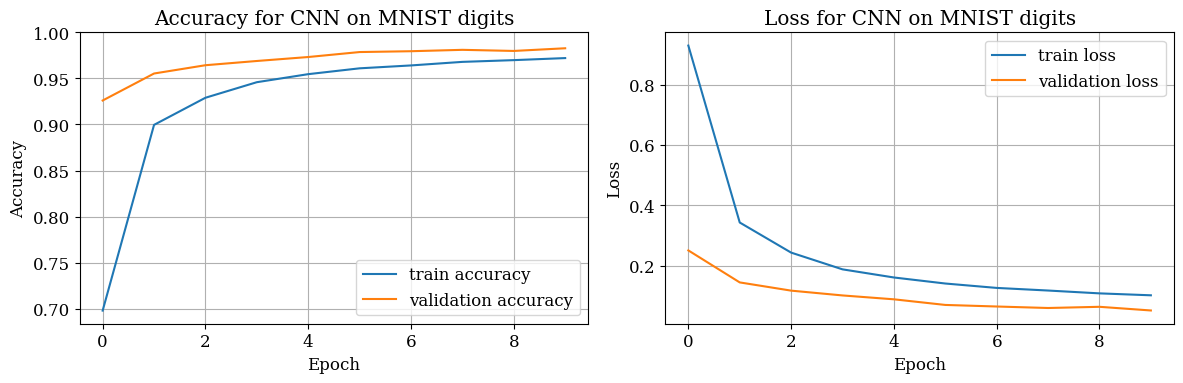

In [11]:
#plot accuracy and loss
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(model_CNN.history.history['acc'], label='train accuracy')
ax[0].plot(model_CNN.history.history['val_acc'], label='validation accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].set_yticks(np.arange(0.7, 1.0, 0.05))
ax[0].set_title('Accuracy for CNN on MNIST digits')
ax[0].grid()
ax[0].legend()

ax[1].plot(model_CNN.history.history['loss'], label='train loss')
ax[1].plot(model_CNN.history.history['val_loss'], label='validation loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_title('Loss for CNN on MNIST digits')
ax[1].grid()
ax[1].legend()
plt.tight_layout()
plt.show()

From these plots we can see the power of convolutional neural networks, The accuracy on the test set is around 98%, which is comparable to the performance of the DNN trained in the previous exercise. For this simple task the CNN is not much better than the DNN, but it is able to use the spatial information of the image, which is a big advantage for more complex tasks especially in image classification.

**On The validation loss:** from the validation loss plot, of the CNN (but also of the DNN), we can see that the validation loss is lower than the training loss, this is due to the dropout layer. Turning off some neurons during training helps the model to generalize better, increasing a little the training loss but preventing overfitting and improving the validation loss.

## Exercise 12.3

Use the `gimp` application to create 10 pictures of your "handwritten" digits, import them in your jupyter-notebook and try to see if your CNN is able to recognize your handwritten digits.

## Solution

In [12]:
from PIL import Image
import os

digit_filenames = [f"pictures/{i}.png" for i in range(0,10)]
digit_in = [Image.open(filename).convert('L') for filename in digit_filenames]

ydim, xdim = digit_in[0].size
print("Image dimensions:", xdim, "x",ydim)
data = np.zeros((10, ydim, xdim))
for i in range(10):
    for y in range(ydim):
        for x in range(xdim):
            data[i, y, x] = digit_in[i].getpixel((x, y)) / 255.0

Image dimensions: 28 x 28


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
accuracy DNN: 50.0%


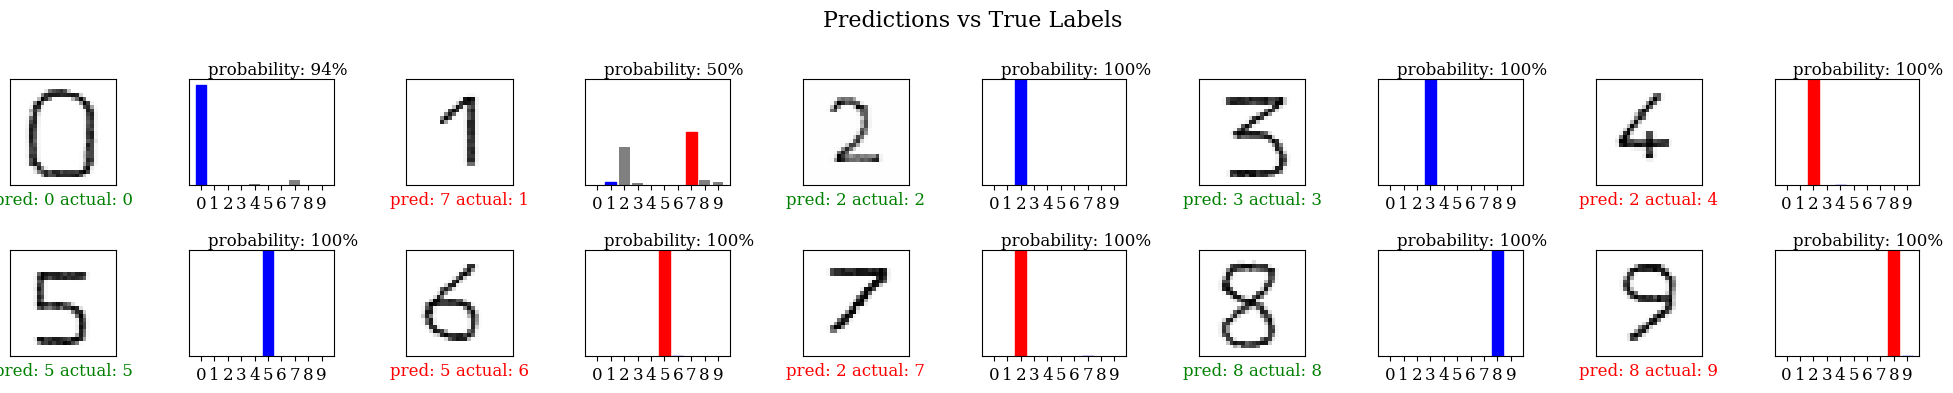

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
accuracy CNN: 70.0%


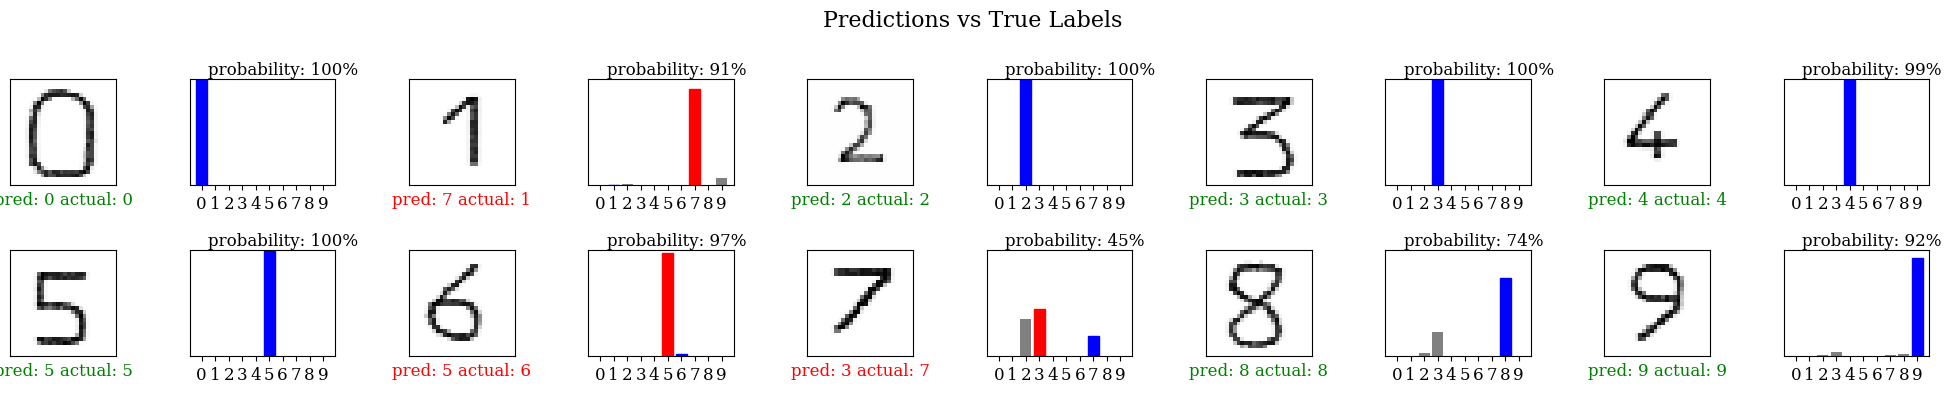

In [13]:
images_custom = data.reshape(10, ydim, xdim)
labels_custom = np.arange(10)  

# DNN Predictions
data_flat = data.reshape(10, -1)  # shape (10, 784)
predictions_dnn = best_model_DNN.predict(data_flat)
print("accuracy DNN:", f"{np.mean(np.argmax(predictions_dnn, axis=1) == labels_custom)*100}%")
plot_predictions(predictions_dnn, images_custom, labels_custom, class_names=class_names, rows=2, cols=5)

# CNN Predictions
predictions_cnn = model_CNN.predict(data.reshape(10, ydim, xdim, 1))
print("accuracy CNN:", f"{np.mean(np.argmax(predictions_cnn, axis=1) == labels_custom)*100}%")
plot_predictions(predictions_cnn, images_custom, labels_custom, class_names=class_names, rows=2, cols=5)

From the prediction plots we can observe that the CNN performs better on digits made by me. It struggles on 1, i think this is due to the fact that in the MNIST dataset the number 1 is written with only a vertical line so it is confused as the number 7 rotated

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


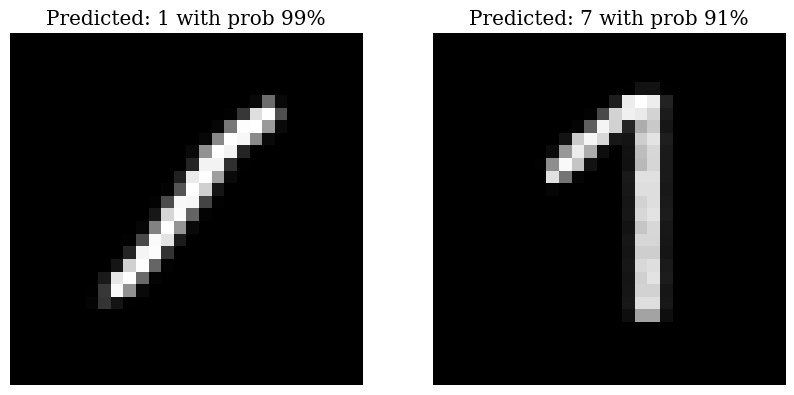

In [14]:
filename = "pictures/1_diff.png"
filename2 = "pictures/1.png"
image = Image.open(filename).convert('L')
image2 = Image.open(filename2).convert('L')

ydim, xdim = image.size
data_diff = np.zeros((ydim, xdim))
data_diff2 = np.zeros((ydim, xdim))

for j in range(ydim):
    for i in range(xdim):
        data_diff[i,j] = image.getpixel((j,i)) / 255.0
        data_diff2[i,j] = image2.getpixel((j,i)) / 255.0
     

#predict image label with cnn
data_diff = data_diff.reshape(1, ydim, xdim, 1)
pred_diff = model_CNN.predict(data_diff)
data_diff2 = data_diff2.reshape(1, ydim, xdim, 1)
pred_diff2 = model_CNN.predict(data_diff2)


fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(data_diff.reshape(ydim, xdim), cmap='gray')
ax[0].set_title(f"Predicted: {np.argmax(pred_diff)} with prob {np.max(pred_diff)*100:.0f}%")
ax[0].axis('off')
ax[1].imshow(data_diff2.reshape(ydim, xdim), cmap='gray')
ax[1].set_title(f"Predicted: {np.argmax(pred_diff2)} with prob {np.max(pred_diff2)*100:.0f}%")
ax[1].axis('off')

plt.show()

### What about rotated or not centered digits?

The MNIST dataset contains centered and correctly oriented digits, so the model is trained to recognize digits in that specific format. When we introduce rotated or not centered digits, the model's performance may degrade significantly.

I tried to rotate the digits and see how the model performs, and as expected, the accuracy drops significantly. The model is not able to recognize the digits anymore, as it has never seen such data during training.

Image dimensions: 28 x 28
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
accuracy DNN: 40.0%


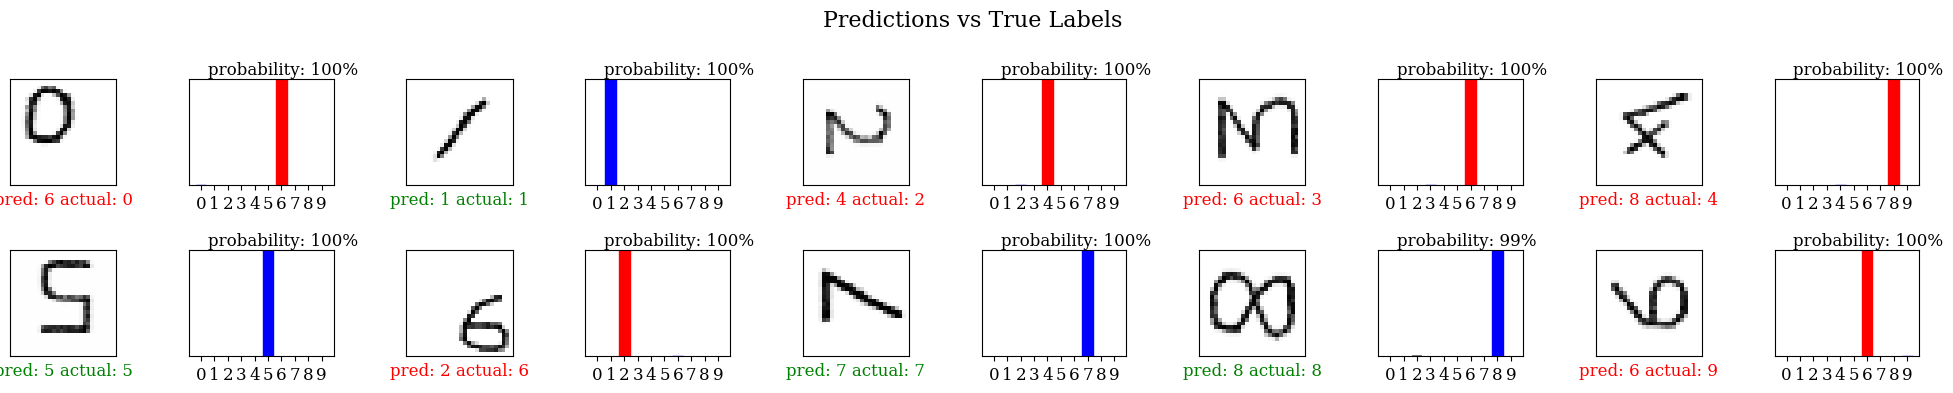

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
accuracy CNN: 50.0%


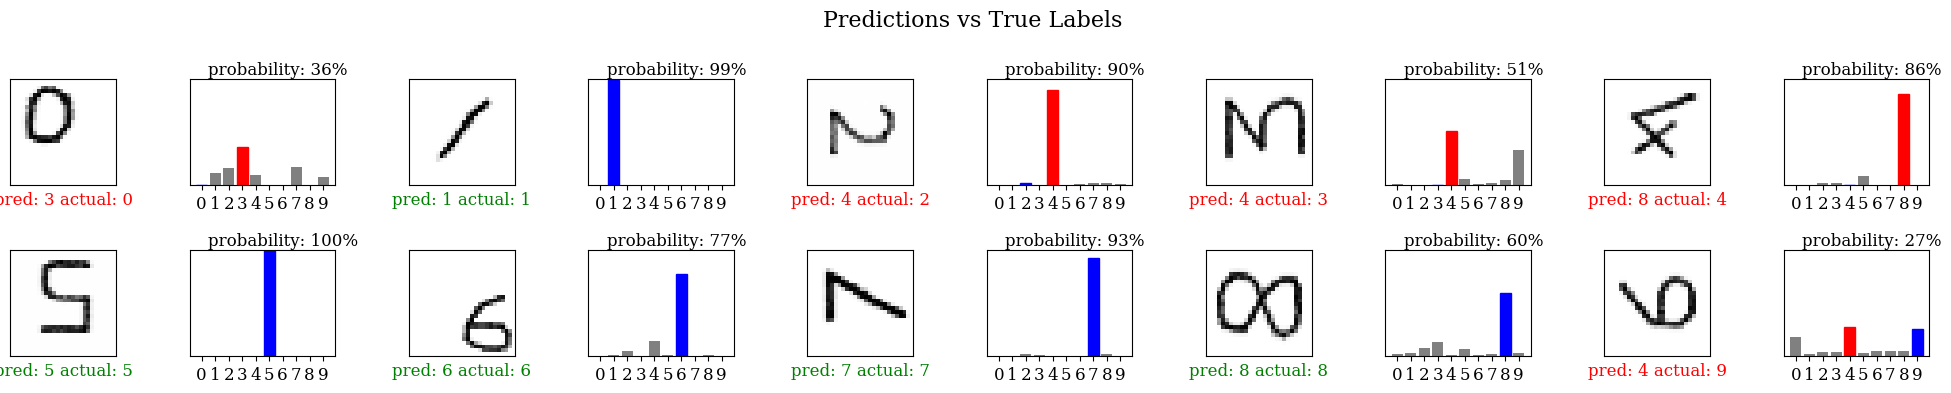

In [15]:
digit_filenames = [f"pictures/{i}_diff.png" for i in range(0,10)]
digit_in = [Image.open(filename).convert('L') for filename in digit_filenames]

ydim, xdim = digit_in[0].size
print("Image dimensions:", xdim, "x",ydim)
data = np.zeros((10, ydim, xdim))
for i in range(10):
    for y in range(ydim):
        for x in range(xdim):
            data[i, y, x] = digit_in[i].getpixel((x, y)) / 255.0

images_custom = data.reshape(10, ydim, xdim)
labels_custom = np.arange(0,10)  

# DNN Predictions
data_flat = data.reshape(10, -1)  # shape (10, 784)
predictions_dnn = best_model_DNN.predict(data_flat)
print("accuracy DNN:", f"{np.mean(np.argmax(predictions_dnn, axis=1) == labels_custom)*100}%")
plot_predictions(predictions_dnn, images_custom, labels_custom, class_names=class_names, rows=2, cols=5)

# CNN Predictions
predictions_cnn = model_CNN.predict(data.reshape(10, ydim, xdim, 1))
print("accuracy CNN:", f"{np.mean(np.argmax(predictions_cnn, axis=1) == labels_custom)*100}%")
plot_predictions(predictions_cnn, images_custom, labels_custom, class_names=class_names, rows=2, cols=5)

Both models struggles to identify the right label, the motivation is in the train dataset, all the digits are written correctly and centered. 

A technique used in deep learning to improve performance is **data augmentation**. This technique consist in rotating, inverting, zooming (and other transformations) the images from the dataset and adding them to the training data

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

X_train_cnn = X_train.reshape(-1, 28, 28, 1)
X_test_cnn = X_test.reshape(-1, 28, 28, 1)

datagen = ImageDataGenerator(
    rotation_range=90,      
    width_shift_range=0.2,  
    height_shift_range=0.2, 
    zoom_range=0.2,         
    shear_range=10,         
    fill_mode='nearest'     
)

datagen.fit(X_train_cnn)
val_datagen = ImageDataGenerator()

batch_size = 32
epochs = 50

model_CNN_aug = create_CNN()

history = model_CNN_aug.fit(
    datagen.flow(X_train_cnn, Y_train, batch_size=batch_size),
    steps_per_epoch=len(X_train_cnn) // batch_size,
    epochs=epochs,
    validation_data=val_datagen.flow(X_test_cnn, Y_test, batch_size=batch_size),
    validation_steps=len(X_test_cnn) // batch_size,
    verbose=0,
    callbacks=[TqdmCallback(verbose=1, leave=True, desc="Training CNN with Augmentation")],
)

Training CNN with Augmentation: 0epoch [00:00, ?epoch/s]

Training CNN with Augmentation: 0batch [00:00, ?batch/s]

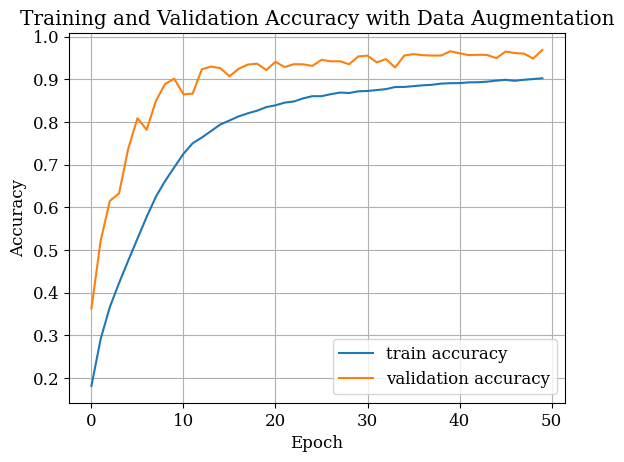

In [17]:
plt.plot(history.history['acc'], label='train accuracy')
plt.plot(history.history['val_acc'], label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy with Data Augmentation')
plt.grid()
plt.legend()
plt.show()

We can see that the model has learned to recognize the digits even if they are rotated or not centered, achieving an accuracy of over 90% on the test set. This is a significant improvement compared to the previous models, which were not able to recognize the digits at all.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
accuracy CNN on original digits: 90.0%


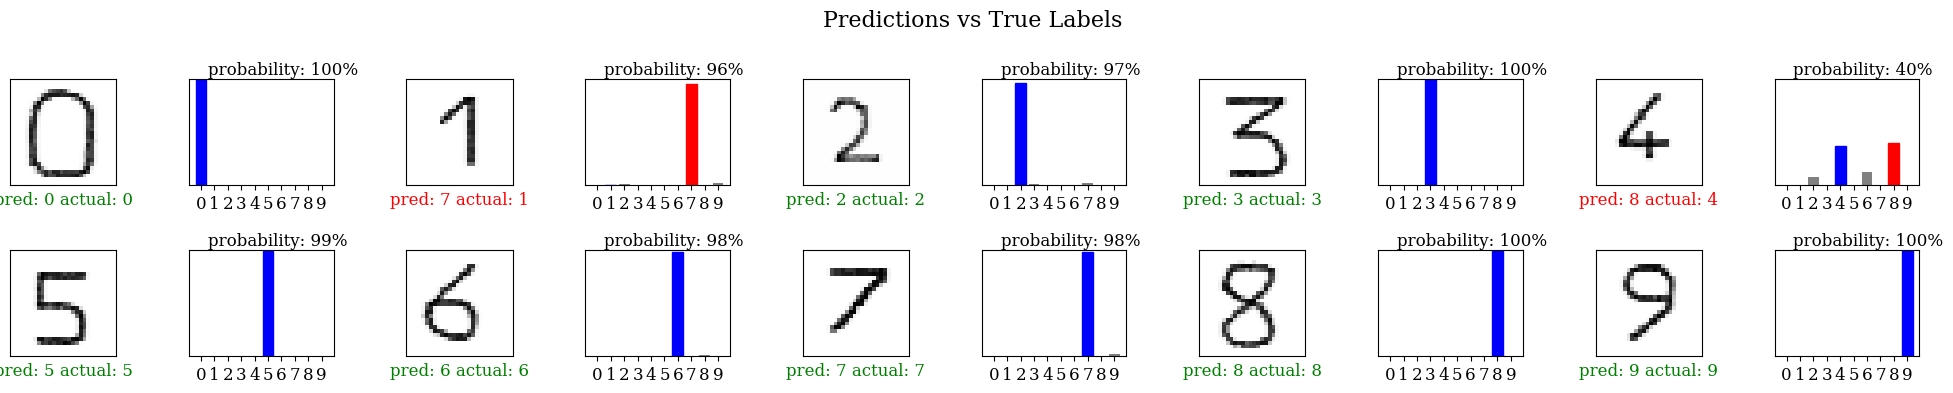

accuracy CNN on modified digits: 90.0%


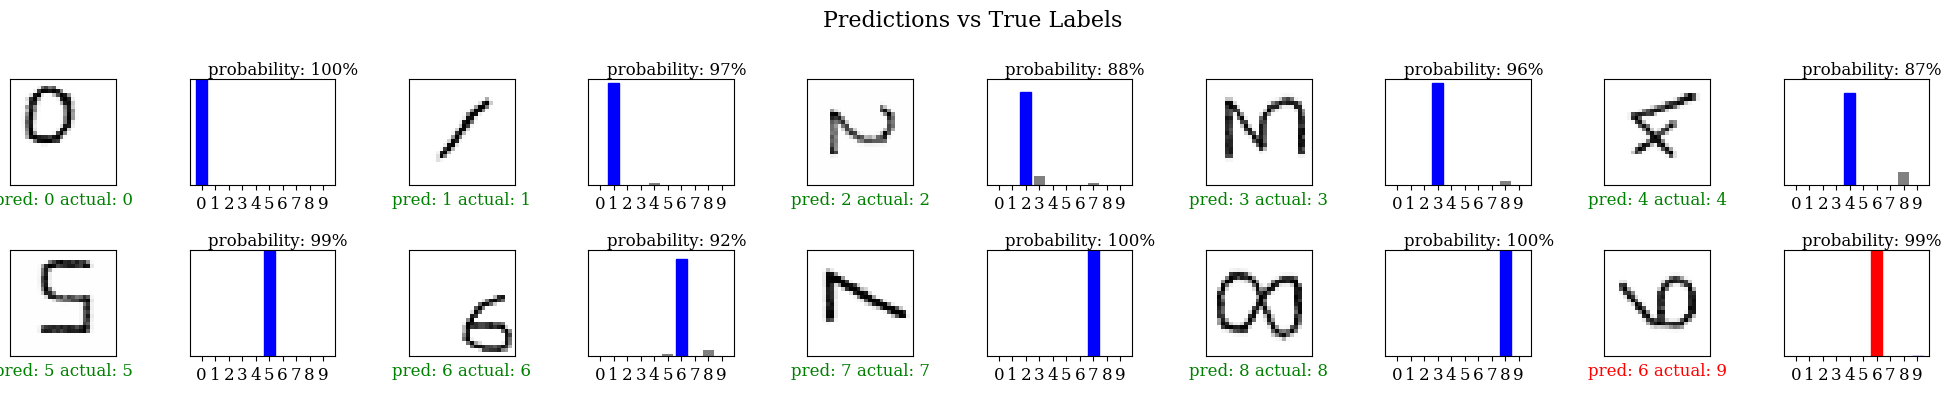

In [18]:
digit_filenames_original = [f"pictures/{i}.png" for i in range(0,10)]
digit_in_original = [Image.open(filename).convert('L') for filename in digit_filenames_original]

digit_filenames = [f"pictures/{i}_diff.png" for i in range(0,10)]
digit_in = [Image.open(filename).convert('L') for filename in digit_filenames]

ydim, xdim = digit_in[0].size

data_original = np.zeros((10, ydim, ydim))
data = np.zeros((10, ydim, xdim))

for i in range(10):
    for y in range(ydim):
        for x in range(xdim):
            data[i, y, x] = digit_in[i].getpixel((x, y)) / 255.0
            data_original[i, y, x] = digit_in_original[i].getpixel((x, y)) / 255.0

images_custom_original = data_original.reshape(10, ydim, xdim)
images_custom = data.reshape(10, ydim, xdim)
labels_custom = np.arange(0, 10)

# Predizioni con la CNN allenata con data augmentation
predictions_cnn_aug = model_CNN_aug.predict(data.reshape(10, ydim, xdim, 1))
predictions_original = model_CNN_aug.predict(data_original.reshape(10, ydim, xdim, 1))
print("accuracy CNN on original digits:", f"{np.mean(np.argmax(predictions_cnn_aug, axis=1) == labels_custom)*100}%")
plot_predictions(predictions_original, images_custom_original, labels_custom, class_names=class_names, rows=2, cols=5)
print("accuracy CNN on modified digits:", f"{np.mean(np.argmax(predictions_cnn_aug, axis=1) == labels_custom)*100}%")
plot_predictions(predictions_cnn_aug, images_custom, labels_custom, class_names=class_names, rows=2, cols=5)

With the same CNN model the accuracy improves from 40% to the 70% on the modified digits. From the upper plot we see that the model still predict correctly the original digits


### AI: A Personal Take
The results are exciting, though by looking at the wrong figures —which are the exact same numbers it has seen tens of thousands of times— one might think these "artificial intelligences" aren't so intelligent after all. A human, looking at images and using a minimum of logic, understands it's a rotated number. It's precisely this reasoning, which seems trivial to us, that differentiates us from these networks. Let's remember that predictions are based on prior training where weights were brutally updated to minimize a cost function. The human capacity for abstraction and logic has not (yet) been achieved even by the most advanced LLMs, which base their speech on a pure prediction of the next token based on previous ones.

So, in conclusion, what we can say is that in the field of machine learning and deep learning, astounding progress has been made, and very important results have been achieved. Most likely, they will continue to surprise us even more. However, I believe that for now, the phrase to keep in mind is <span style="color:brown">**"Prediction is not Reasoning"**</span>.